### ***Install CUDA-10.2***

##### *Uninstall current CUDA version*

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*

In [ ]:
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge

In [ ]:
!apt-get remove cuda-*

In [ ]:
!apt-get update

##### *Install CUDA-10.2*

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/10.2/Prod/local_installers/cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb -O cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!apt-key add /var/cuda-repo-10-2-local/7fa2af80.pub
!apt-get update
!apt-get -y install cuda-10.2

In [ ]:
!nvidia-smi
print("\n >> GPU name:", torch.cuda.get_device_name(0))
print("\n >> CUDA informations: ")
!nvcc -V

Tue Jan 31 15:00:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#   Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Install some dependencies: 
!pip install pyyaml==5.3
!pip install torch==1.10.0+cu102 torchvision==0.11.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.2/268.2 KB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.3-cp38-cp38-linux_x86_64.whl size=44243 sha256=d7be5196f57d45421e3d5fbc039b64dd2684f40b53418bfdbf641995606871ad
  Stored in directory: /root/.cache/pip/wheels/e4/94/ec/65e430f66fda7a86c08f61ce59455581adc269a65881b4ffeb
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [ ]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.11.0+cu102


#### ***Install detectron2 (with PyTorch==1.8)***


###### *https://detectron2.readthedocs.io/en/latest/tutorials/install.html#:~:text=pip%20install%20detectron2%20%2Df%20%5C%0A%20%20https%3A//dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html*

In [ ]:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html

In [ ]:
import detectron2
print("Detectron2 version: ", detectron2.__version__)

Detectron2 version:  0.6


In [ ]:
%%writefile detectron2ts.py
import sys, os
import csv 
import cv2, torch
import argparse
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(" >> Computation device:", torch.cuda.get_device_name(0))

# Import some common detectron2 utilities
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.modeling import meta_arch
from detectron2.utils.visualizer import Visualizer
setup_logger()

#   Config setup...
cfg = get_cfg()
model_config = "/content/config.yaml"
cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/TOW/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
#   Setup device
cfg.MODEL.DEVICE = device


#   Visualize an image
def cv2_imshow(img, filename, infer=False):
    # plt.figure(figsize=(15, 10))
    plt.imshow(img[:, :, [2, 1, 0]])  #     <=> plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    #   Visualize with TorchScript
    if infer:
        if not os.path.isdir("/content/TS_results"):
            os.mkdir("/content/TS_results")
        plt.savefig(os.path.join("/content/TS_results", filename))
    #   Visualize with DefaultPredictor
    else:
        if not os.path.isdir("/content/DF_results"):
            os.mkdir("/content/DF_results")
        plt.savefig(os.path.join("/content/DF_results", filename))


# ==============================================================================
# ====================== Visualize with Default Predictor ======================
# ==============================================================================

def viz_result(org_img, img_size, csv_writer, args):
    for size in img_size:
        #   Resize image to specified size
        img = cv2.resize(org_img, size)

        #   Use the detectron2 `DefaultPredictor` to run inference on this image.
        predictor = DefaultPredictor(cfg)
        preds = predictor(img)
#        preds, elaps_time = predictor(img)

#        print(" >> Size:", size)
#        print(f" >> Elaps time: {elaps_time:.3f}s.")
#        print(f" >> FPS: {1/elaps_time:.1f}")
#        print("==================================")

#        #   Write results to csv file
#        csv_writer.writerow([size, round(elaps_time, 3), round(1/elaps_time, 1), "pth"])

        #   We can use `Visualizer` to draw the predictions on the image.
        v = Visualizer(img[:, :, ::-1], None, scale=1, instance_mode=ColorMode.IMAGE_BW)
        out = v.draw_instance_predictions(preds["instances"].to("cpu"))
        cv2_imshow(out.get_image()[:, :, ::-1], str(size) + args.default_pred)


# ==================================================================================
# ===================== Export detectron2 model to TorchScript =====================
# ==================================================================================

from torch import Tensor
from detectron2.structures import Boxes
from typing import Dict, List, Tuple
from detectron2.modeling import build_model, GeneralizedRCNN
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.file_io import PathManager
from detectron2.export.torchscript import dump_torchscript_IR
from detectron2.export.torchscript import scripting_with_instances
from detectron2.utils.visualizer import ColorMode


def export_torchscript(args):
    fields = {"proposal_boxes": Boxes,
              "objectness_logits": Tensor,
              "pred_boxes": Boxes,
              "scores": Tensor,
              "pred_classes": Tensor,
              "pred_masks": Tensor,
            }
            
    torch_model = build_model(cfg)
    DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)
    torch_model.eval()

    class ScriptableAdapterBase(nn.Module):
        # Use this adapter to workaround https://github.com/pytorch/pytorch/issues/46944
        # by not retuning instances but dicts. Otherwise the exported model is not deployable
        def __init__(self):
            super().__init__()
            self.model = torch_model
            self.eval()

    if isinstance(torch_model, GeneralizedRCNN):    # Code se chay ham nay (Vi torch_model la 1 GeneralizedRCNN)
        class ScriptableAdapter(ScriptableAdapterBase):
            def forward(self, inputs: Tuple[Dict[str, torch.Tensor]]) -> List[Dict[str, Tensor]]:
                instances = self.model.inference(inputs, do_postprocess=False)
                return [i.get_fields() for i in instances]
    else:
        class ScriptableAdapter(ScriptableAdapterBase):
            def forward(self, inputs: Tuple[Dict[str, torch.Tensor]]) -> List[Dict[str, Tensor]]:
                instances = self.model(inputs)
                return [i.get_fields() for i in instances]

    if not os.path.isdir("/content/ts_model"):
      os.mkdir("/content/ts_model")

    ts_model = scripting_with_instances(ScriptableAdapter(), fields)
    with PathManager.open(os.path.join("/content/ts_model", args.export_ts), "wb") as f:
        torch.jit.save(ts_model, f)
    dump_torchscript_IR(ts_model, "/content/ts_model")


# ====================================================================
# ==================== Inference with TorchScript ====================
# ====================================================================

from detectron2.export.caffe2_modeling import assemble_rcnn_outputs_by_name
from time import perf_counter, process_time
import time

def torchscript_infer(org_img, img_size, csv_writer, args):
    #   Load TorchScript model
    ts_model = torch.jit.load(os.path.join("ts_model", args.infer_ts)).to(device)
    # time.sleep(10)
    start_count = process_time()
    while(True):
        #   Waiting for system stablity in 10 seconds
        if(round(process_time() - start_count, 1) == 10.0):
            break

    for size in img_size:
        #   Resize image to specified size
        org_img = cv2.resize(org_img, size)
        height, width = org_img.shape[:2]
        image_sizes = [org_img.shape[:2]]

        img = torch.as_tensor(org_img).to(device)
        with torch.no_grad():
            img = img.permute(2, 0, 1).float()

            start = perf_counter()
            results = ts_model([{"image": img}])[0]
            elaps_time = perf_counter() - start

            """ 

                =========== Parse torchscript outputs ============
                results: [{
                            'pred_boxes': float_Tensor,
                            'scores': float_Tensor,
                            'pred_classes': int_Tensor,
                            'pred_masks': float_Tensor
                        }]

            """

            output_custom = {
                                "bbox_nms": results['pred_boxes'],
                                "score_nms": results['scores'],
                                "class_nms": results['pred_classes'],
                                "mask_fcn_probs": results['pred_masks']
                            }

            results = assemble_rcnn_outputs_by_name(image_sizes, output_custom, force_mask_on=True)
            inputs = {"image": img, "height": height, "width": width}
            # Replace with the used model
            outputs = getattr( meta_arch, cfg.MODEL.META_ARCHITECTURE)._postprocess(results, [inputs], image_sizes )

            print(" >> Size:", size)
            print(f" >> Elaps time: {elaps_time:.3f}s.")
            print(f" >> FPS: {1/elaps_time:.1f}")
            print("==================================")

            #   Write results to csv file
            csv_writer.writerow([size, round(elaps_time, 3), round(1/elaps_time, 1), "torchscript"])
            
            #   Visualization
            v = Visualizer(org_img[:, :, ::-1], None, scale=1, instance_mode=ColorMode.IMAGE_BW)
            out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
            cv2_imshow(out.get_image()[:, :, ::-1], str(size) + args.input_img, infer = True)


def arg_parser():
    parser = argparse.ArgumentParser(description="Export models for deployment.")

    parser.add_argument("--input_img", type=str, default=None, help='Name of input image.')
    parser.add_argument("--default_pred", type=str, help='Name of image to save.')
    parser.add_argument("--export_ts", type=str, help='Name of exported TorchScript model.')
    parser.add_argument("--infer_ts", type=str, help='File name of TorchScripted model.')
    
    return parser.parse_args()


def main():
    args = arg_parser()
    #   Read image
    org_img = cv2.imread(os.path.join("/content", args.input_img)) 

    img_size = [(200, 200), (300, 300), (400, 400), (500, 500), (600, 600), (800, 800),
                (300, 200), (400, 200), (400, 300), (600, 300), (800, 300), (800, 400)]

    #   Write results to a csv file
    filename = "/content/data.csv"
    
    if args.default_pred: 
        fields = ["Image Size", "Time", "FPS", "Model Type"]   
        with open(filename, 'w') as csvfile:  # OverWrite mode
            # Creating a csv writer object 
            csv_writer = csv.writer(csvfile)         
            # Writing the fields 
            csv_writer.writerow(fields) 
            viz_result(org_img, img_size, csv_writer, args)

    if args.export_ts:
        export_torchscript(args)

    if args.infer_ts:
        with open(filename, 'a') as csvfile:  # Append mode
            # Creating a csv writer object 
            csv_writer = csv.writer(csvfile) 
            torchscript_infer(org_img, img_size, csv_writer, args)


if __name__ == "__main__":
    main()

Writing detectron2ts.py


### ***Visualize with Default Predictor***

In [ ]:
!python /content/detectron2ts.py --input_img "/content/grape.jpg" --default_pred DP_result.jpg

### ***Convert to TorchScript***

In [ ]:
!python /content/detectron2ts.py --input_img grape.jpg --export_ts model.ts

### ***Inference TorchScript***

In [ ]:
!python /content/detectron2ts.py --input_img grape.jpg --infer_ts model.ts

## ***Inference with specified metadata***

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from numpy import load
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask
import pycocotools
import torch
from skimage import measure
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## ***Inference on customer dataset***

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.modeling import meta_arch
from detectron2.utils.visualizer import Visualizer
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
# https://github.com/facebookresearch/detectron2/issues/50?fbclid=IwAR0x2pU6SrHz4oQZRZN45wCkxtT2Wgo0HByvG7vPhI5KKJuhsj8eR1OsPRA
# Conversion of Dataset to COCO Format: https://towardsdatascience.com/object-detection-in-6-steps-using-detectron2-705b92575578

import json
import os
import cv2
import numpy as np
from detectron2.structures import BoxMode

def get_grape_dicts(img_path, json_path):
    with open(json_path) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []

    for img in imgs_anns['images']:
        record = {}
        
        filename = os.path.join(img_path[''][1] + annos['bbox'][3])                 
                obj = {"bbox": bbox,
                       "bbox_mode": BoxModh,img['file_name'])
        height, width = cv2.imread(filename).shape[:2]
        img_id = img['id']

        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = img['id']
        
        objs = []
        for annos in imgs_anns['annotations']:
            if annos['image_id'] == img_id:

                poly = annos['segmentation']
                bbox = []
                bbox.append(annos['bbox'][0])
                bbox.append(annos['bbox'][1])      
                bbox.append(annos['bbox'][0] + annos['bbox'][2])      
                bbox.append(annos['bbox'][1] + annos['bbox'][3])                 
                obj = {"bbox": bbox,
                       "bbox_mode": BoxMode.XYXY_ABS,
                       "segmentation": poly,
                       "category_id": 0,
                       "iscrowd": 0}
                objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


DatasetCatalog.register("my_test", lambda: get_grape_dicts("/content/drive/MyDrive/TOW/Grape_Test/coco-segmentation/test", "/content/drive/MyDrive/TOW/Grape_Test/coco-segmentation/test/anno.json"))
MetadataCatalog.get("my_test").set(thing_classes=["cluster"])
# dt = get_grape_dicts("/content/drive/MyDrive/TOW/Grape_Test/coco-segmentation/test", "/content/drive/MyDrive/TOW/Grape_Test/coco-segmentation/test/anno.json")


In [ ]:
# from detectron2.data.datasets import register_coco_instances

# register_coco_instances("my_test", {}, "/content/anno.json", "/content/drive/MyDrive/TOW/Grape_Test/test")

In [ ]:
#   Config setup...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg = get_cfg()
model_config = "/content/config.yaml"
cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/TOW/Grape_Test/model_final.pth"
#   Setup device
cfg.MODEL.DEVICE = device
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.DATASETS.TEST = ("my_test",)

In [ ]:
predictor = DefaultPredictor(cfg)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_test", cfg, False, output_dir="/content/output")
val_loader = build_detection_test_loader(cfg, "my_test")
print_csv_format(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
im = cv2.imread("/content/grapee.png")

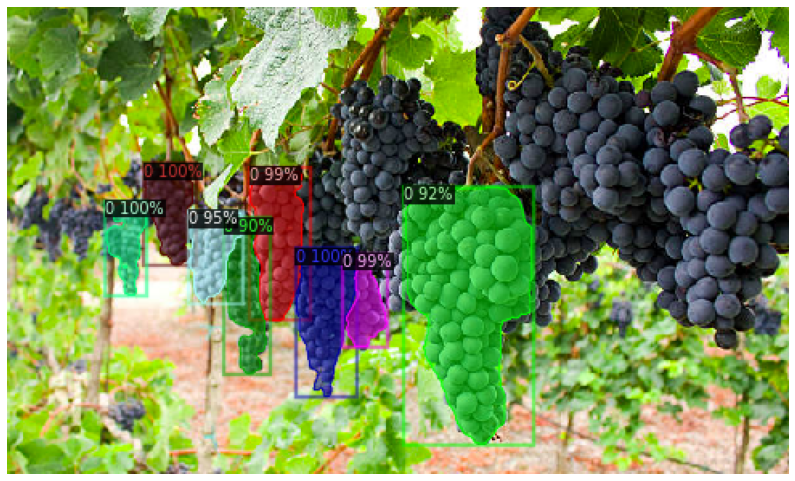

In [ ]:
predictor = DefaultPredictor(cfg)

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("/content/grapee_.jpg")
plt.show()